This notebook implement a Recurrent Neural Network (RNN) for power system event calssification. 

The workflow includes data preprocessing, sequence construction, model training and evaluation.

To reproduce the results, run all cell sequentially. The dataset file should be placed in the same directory as this notebook.

## Data Loading and Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

import matplotlib.pyplot as plt
import seaborn as sns

#Reproducibility
Seed = 42
np.random.seed(Seed)
torch.manual_seed(Seed)
# device setting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


### Load the data 

In [2]:
file_path = 'Bus39_Competition_Data.xlsx'
df = pd.read_excel(file_path, engine='openpyxl')

In [3]:
df = df.sort_values('TIMESTAMP').reset_index(drop=True)
x_raw = df.drop(['TIMESTAMP','Event'],axis=1).values
y_raw = df['Event'].values

### Data preprocessing

In [4]:
missing_values = df.isnull().sum()
print(missing_values)

TIMESTAMP       0
BUS39_VA_ANG    0
BUS39_VA_MAG    0
BUS39_VB_ANG    0
BUS39_VB_MAG    0
BUS39_VC_ANG    0
BUS39_VC_MAG    0
BUS39_IA_ANG    0
BUS39_IA_MAG    0
BUS39_IB_ANG    0
BUS39_IB_MAG    0
BUS39_IC_ANG    0
BUS39_IC_MAG    0
BUS39_Freq      0
BUS39_ROCOF     0
Event           0
dtype: int64


According to the results of isnull().sum(), the dataset contains no missing values. Therefore, all raw data are preserved without any additional processing.

### Data split and standardization

In [5]:
encode = LabelEncoder()
y_encoded = encode.fit_transform(y_raw)
print(f'Classes: {encode.classes_}')

X_train, X_test, y_train, y_test = train_test_split(
    x_raw, y_encoded, test_size=0.2, random_state=Seed, shuffle=True, stratify=y_encoded    
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Classes: [0 1 2 3 4 7]


### Create sequence

In [6]:
def create_sequences(X,y,sequence_length):
    xs,ys = [],[]
    for i in range(len(X)-sequence_length +1):
        x_i = X[i:(i+sequence_length)]
        y_i = y[i+sequence_length-1]
        xs.append(x_i)
        ys.append(y_i)
    return np.array(xs),np.array(ys)

In [7]:
sequence = 10

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, sequence)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test,  sequence)

print(X_train_seq.shape)
print(y_train_seq.shape)
print(X_test_seq.shape)
print(y_test_seq.shape)

(129094, 10, 14)
(129094,)
(32267, 10, 14)
(32267,)


### Batch loading

In [8]:
class PMUDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
train_dataset = PMUDataset(X_train_seq, y_train_seq)
test_dataset = PMUDataset(X_test_seq, y_test_seq)

In [9]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for xb, yb in train_loader:
    print("Batch X shape:", xb.shape)
    print("Batch y shape:", yb.shape)
    break

Batch X shape: torch.Size([64, 10, 14])
Batch y shape: torch.Size([64])


# Model Design

In [10]:
class RNNclassifier(nn.Module):
    def __init__(self,input_size,hidden_size,num_layer,num_classes):
        super(RNNclassifier,self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layer,
            batch_first=True,
            nonlinearity='tanh'
        )
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(hidden_size,num_classes)
    def forward(self,x):
        out,hidden = self.rnn(x)
        out = out[:,-1,:]
        out = self.dropout(out)
        out = self.fc(out)
        return out

### Parameters setting

In [11]:
input_size =14
hidden_size = 32
num_layers = 2
num_classes = len(encode.classes_)
model = RNNclassifier(input_size,hidden_size,num_layers,num_classes).to(device)
model.to(device)

RNNclassifier(
  (rnn): RNN(14, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=32, out_features=6, bias=True)
)

### loss function and optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)

### training process

In [ ]:
train_losses = []
val_losses = []
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for xb,yb in train_loader:
        xb,yb = xb.to(device),yb.to(device)

        outputs = model(xb)
        loss = criterion(outputs,yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_running_loss += loss.item()

    epoch_val_loss = val_running_loss / len(test_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Train Loss: {epoch_train_loss:.4f}  "
          f"Val Loss: {epoch_val_loss:.4f}")

Epoch [1/20]  Train Loss: 0.0983  Val Loss: 0.0367
Epoch [2/20]  Train Loss: 0.0336  Val Loss: 0.0310
Epoch [3/20]  Train Loss: 0.0251  Val Loss: 0.0193
Epoch [4/20]  Train Loss: 0.0184  Val Loss: 0.0163
Epoch [5/20]  Train Loss: 0.0160  Val Loss: 0.0146
Epoch [6/20]  Train Loss: 0.0149  Val Loss: 0.0142
Epoch [7/20]  Train Loss: 0.0139  Val Loss: 0.0130
Epoch [8/20]  Train Loss: 0.0135  Val Loss: 0.0129
Epoch [9/20]  Train Loss: 0.0127  Val Loss: 0.0144
Epoch [10/20]  Train Loss: 0.0125  Val Loss: 0.0125
Epoch [11/20]  Train Loss: 0.0125  Val Loss: 0.0120
Epoch [12/20]  Train Loss: 0.0114  Val Loss: 0.0118
Epoch [13/20]  Train Loss: 0.0117  Val Loss: 0.0147
Epoch [14/20]  Train Loss: 0.0114  Val Loss: 0.0110
Epoch [15/20]  Train Loss: 0.0113  Val Loss: 0.0116
Epoch [16/20]  Train Loss: 0.0108  Val Loss: 0.0099
Epoch [17/20]  Train Loss: 0.0108  Val Loss: 0.0122
Epoch [18/20]  Train Loss: 0.0111  Val Loss: 0.0106
Epoch [19/20]  Train Loss: 0.0104  Val Loss: 0.0110
Epoch [20/20]  Train 

# Evaluation and Metrics

In [14]:
all_preds =[]
all_true =[]
model.eval()
with torch.no_grad():
    for xb,yb in test_loader:
        xb,yb = xb.to(device),yb.to(device)
        outputs = model(xb)
        _,predicted = torch.max(outputs.data,1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(yb.cpu().numpy())
        
print("Accuracy: ", accuracy_score(all_true, all_preds))
print("\nClassification Report:\n")
print(classification_report(all_true, all_preds, digits=4))

Accuracy:  0.9977996095081663

Classification Report:

              precision    recall  f1-score   support

           0     0.9985    0.9998    0.9991     28471
           1     0.8421    0.5333    0.6531        30
           2     0.6957    0.6400    0.6667        25
           3     0.9963    0.9858    0.9910      1904
           4     0.9940    0.9945    0.9943      1826
           5     1.0000    0.5455    0.7059        11

    accuracy                         0.9978     32267
   macro avg     0.9211    0.7832    0.8350     32267
weighted avg     0.9977    0.9978    0.9977     32267



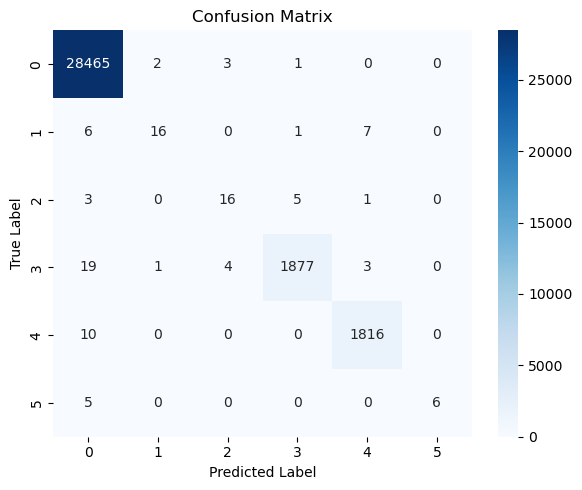

In [15]:
cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

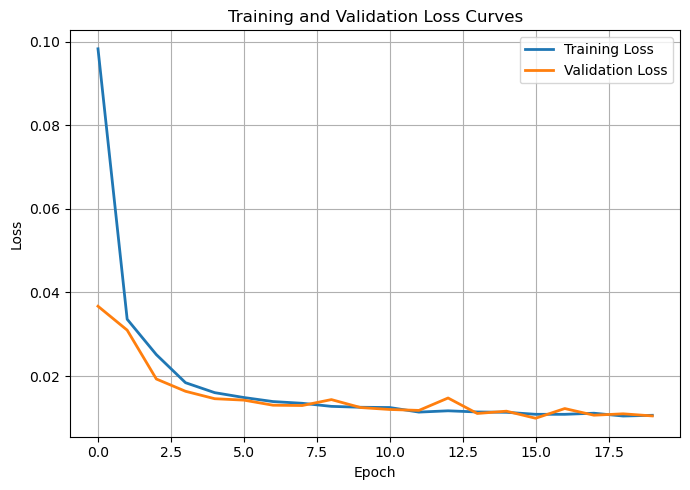

In [16]:
plt.figure(figsize=(7,5))
plt.plot(train_losses, label="Training Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Replace the original loss with weighted cross-entropy to mitigate class imbalance.

In [17]:
class_counts = np.bincount(y_train)
num_classes = len(class_counts)
class_weights = (len(y_train))/(num_classes * class_counts)**0.5
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)